In [5]:
from pyspark.sql import SparkSession
import pp_events as pp

In [2]:
spark = SparkSession.builder.appName('export_sff').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/21 02:10:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
events = spark.read.csv('Data/events.csv',header=True,inferSchema=True,sep=';')

In [11]:
events_shot = events.filter(events.type=='Shot')

In [12]:
events_shot = pp.split_location(events_shot)
events_shot = pp.distance_to_goal(events_shot)
events_shot = pp.get_shot_angle(events_shot)

In [14]:
ev = events_shot.select('shot_location_x','shot_location_y','distance_to_goal','shot_angle','shot_statsbomb_xg')

In [15]:
ev.show()

+---------------+---------------+----------------+----------+-----------------+
|shot_location_x|shot_location_y|distance_to_goal|shot_angle|shot_statsbomb_xg|
+---------------+---------------+----------------+----------+-----------------+
|          105.6|           44.0|         14.9452| 29.054602|       0.07213958|
|           98.6|           25.2|         26.0192| 14.520617|       0.02977089|
|          105.5|           47.3|         16.2339| 25.108313|       0.07589752|
|          113.4|           38.7|          6.7268| 61.014557|       0.15686217|
|          106.2|           36.8|         14.1662| 30.870586|       0.15133068|
|          108.3|           39.0|         11.7427| 37.520866|      0.049562205|
|           85.6|           34.4|         34.8528|  12.92981|      0.015171255|
|          112.5|           42.5|          7.9057| 52.224316|       0.08510399|
|          106.1|           32.5|         15.7943| 25.469059|       0.02531394|
|           83.5|           48.0|       

In [18]:
# doing an xg model based on the features extracted using MLlib
# shot_statsbomb_xg is the target variable, the rest are the features
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor, GeneralizedLinearRegression, IsotonicRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

features = ["shot_location_x", "shot_location_y", "distance_to_goal", "shot_angle"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(ev).select("features", "shot_statsbomb_xg")

# Split into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize all models
lr = LinearRegression(labelCol="shot_statsbomb_xg", featuresCol="features")
rf = RandomForestRegressor(labelCol="shot_statsbomb_xg", featuresCol="features")
gbt = GBTRegressor(labelCol="shot_statsbomb_xg", featuresCol="features")
dt = DecisionTreeRegressor(labelCol="shot_statsbomb_xg", featuresCol="features")
glr = GeneralizedLinearRegression(labelCol="shot_statsbomb_xg", featuresCol="features")
ir = IsotonicRegression(labelCol="shot_statsbomb_xg", featuresCol="features")

In [ ]:
# Create a list of models
models = [lr, rf, gbt, dt, glr, ir]

# Create a list of model names
model_names = ["Linear Regression", "Random Forest", "Gradient Boosted Trees", "Decision Tree", "Generalized Linear Regression", "Isotonic Regression"]

# Create a list of model pipelines
model_pipelines = [Pipeline(stages=[model]) for model in models]

# Fit each model pipeline
fitted_models = [pipeline.fit(train_data) for pipeline in model_pipelines]

# Evaluate each model
evaluator = RegressionEvaluator(labelCol="shot_statsbomb_xg", predictionCol="prediction", metricName="rmse")
predictions = [fitted_model.transform(test_data) for fitted_model in fitted_models]
rmse = [evaluator.evaluate(prediction) for prediction in predictions]

# Display the RMSE of each model
for i in range(len(models)):
    print(model_names[i] + " RMSE: " + str(rmse[i]))
    
# Time spent to run : 1m 54s for ["shot_location_x", "shot_location_y", "distance_to_goal", "shot_angle"] 0.09
# Time spent to run : 1m 50s for ["distance_to_goal", "shot_angle"]                                       0.10

24/12/21 02:18:09 WARN Instrumentation: [aede7add] regParam is zero, which might cause numerical instability and overfitting.
24/12/21 02:19:16 WARN Instrumentation: [d9643898] regParam is zero, which might cause numerical instability and overfitting.


Linear Regression RMSE: 0.11866663665176325
Random Forest RMSE: 0.10470747475430223
Gradient Boosted Trees RMSE: 0.10425866605680521
Decision Tree RMSE: 0.10529429012317074
Generalized Linear Regression RMSE: 0.11866663665176325
Isotonic Regression RMSE: 0.15127922446191558


In [36]:
from pyspark.sql.functions import col, round, sqrt, format_number

# Calculate RMSE for each row, round it to 7 decimals, and add as a new column
predictions[5].select(
    col('shot_statsbomb_xg').alias('xg'),
    col('prediction').alias('pred')) \
    .withColumn('xg', round('xg', 7)) \
    .withColumn('pred', round('pred', 7)) \
    .withColumn('rmse', format_number(sqrt((col('xg') - col('pred'))**2), 7)).orderBy('rmse').show(100)

+---------+---------+---------+
|       xg|     pred|     rmse|
+---------+---------+---------+
|0.1047731|0.1048335|0.0000604|
|0.1049166|0.1048335|0.0000831|
|0.1049231|0.1048335|0.0000896|
|0.1047084|0.1048335|0.0001251|
|0.1049752|0.1048335|0.0001417|
|0.1046897|0.1048335|0.0001438|
|0.1050003|0.1048335|0.0001668|
|0.1046235|0.1048335|0.0002100|
|0.1046173|0.1048335|0.0002162|
|0.1050574|0.1048335|0.0002239|
|0.1046057|0.1048335|0.0002278|
|0.1046037|0.1048335|0.0002298|
|0.1045934|0.1048335|0.0002401|
|0.1050912|0.1048335|0.0002577|
|0.1051165|0.1048335|0.0002830|
|0.1045499|0.1048335|0.0002836|
|0.1051181|0.1048335|0.0002846|
|0.1051375|0.1048335|0.0003040|
|0.1045229|0.1048335|0.0003106|
|0.1045203|0.1048335|0.0003132|
|0.1045139|0.1048335|0.0003196|
|0.1045137|0.1048335|0.0003198|
|0.1051591|0.1048335|0.0003256|
|0.1051899|0.1048335|0.0003564|
|0.1051955|0.1048335|0.0003620|
|0.1052008|0.1048335|0.0003673|
|0.1052018|0.1048335|0.0003683|
|0.1052027|0.1048335|0.0003692|
|0.10522

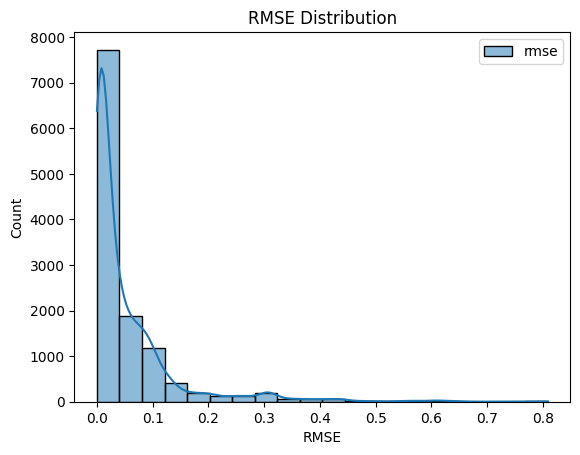

In [41]:
# visualize the distribution of rmse values
import matplotlib.pyplot as plt
import seaborn as sns

rmse_values = predictions[2].select(
    sqrt((col('shot_statsbomb_xg') - col('prediction'))**2).alias('rmse')).toPandas()

sns.histplot(rmse_values, bins=20, kde=True)
plt.title('RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.show()